<a href="https://colab.research.google.com/github/ashishpatel26/Ganpat-University-Data-Science/blob/main/Lecture_6_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1.Install Package(Surprise - Recommendation Framework)

In [1]:
!pip install surprise

     |████████████████████████████████| 11.8MB 330kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617548 sha256=cf1bd822412b16d4d0e6c41bebed322dc5f49cbac16e4934060ca7af83785bfa
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


### 2.Import Libraries

In [90]:
# Imports
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

from surprise import SVD,Reader,Dataset
from surprise.model_selection import cross_validate, KFold

import requests
from PIL import Image
from io import BytesIO
import gc
import warnings
warnings.filterwarnings("ignore")

### 3.Load Dataset

In [17]:
books = pd.read_csv('https://raw.githubusercontent.com/ashishpatel26/Ganpat-University-Data-Science/main/data/books.csv')
ratings = pd.read_csv('https://raw.githubusercontent.com/ashishpatel26/Ganpat-University-Data-Science/main/data/ratings.csv')
tags = pd.read_csv('https://raw.githubusercontent.com/ashishpatel26/Ganpat-University-Data-Science/main/data/tags.csv')
book_tags = pd.read_csv('https://raw.githubusercontent.com/ashishpatel26/Ganpat-University-Data-Science/main/data/book_tags.csv')

### 4.Sanity Check of dataset

In [18]:
# Checking the shapes of the datasets
print(f"The books dataset has: {books.shape[0]} entries.")
print(f"The ratings dataset has: {ratings.shape[0]} entries.")
print(f"The tags dataset has: {tags.shape[0]} entries.")
print(f"The book_tags dataset has: {book_tags.shape[0]} entries.")

The books dataset has: 10000 entries.
The ratings dataset has: 981756 entries.
The tags dataset has: 34252 entries.
The book_tags dataset has: 999912 entries.


###  5.Checking the Missing Values

In [19]:
# Check for missing Values
print("Is there NaN values? \n On books dataset:",  books.isnull().values.any(),
      "\n On ratings dataset:", ratings.isnull().values.any(),
      "\n On tags dataset:", tags.isnull().values.any(),
      "\n On book_tags dataset:", book_tags.isnull().values.any())

Is there NaN values? 
 On books dataset: True 
 On ratings dataset: False 
 On tags dataset: False 
 On book_tags dataset: False


In [20]:
null_counts = books.isnull().sum()
null_counts[null_counts>0]

isbn                          700
isbn13                        585
original_publication_year      21
original_title                585
language_code                1084
dtype: int64

In [21]:
print("Oldest book: ", books['original_publication_year'].min())
print("Newer book: ", books['original_publication_year'].max())

Oldest book:  -1750.0
Newer book:  2017.0


### 6.Delete NaN values of original_publication_year

In [22]:
# Delete NaN values of original_publication_year
for x in ["original_publication_year"]:
    books = books[books[x].notnull()]

# Delete negative values
books = books[(books['original_publication_year'] >= 0)]
print("Now we have", books.shape[0], "entrances.")

Now we have 9948 entrances.


### 7. Dropping the unessesary columnn

In [23]:
# Print the head of the books dataset.
pd.set_option('display.max_columns', None)
books.head(3)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...


In [24]:
# Drop the columns that we don't need.
books.drop(['best_book_id','work_id','work_ratings_count','ratings_1', 'ratings_2','ratings_3','ratings_4','ratings_5','small_image_url','isbn','isbn13'], axis=1,inplace=True)

In [25]:
# Print head of the ratings dataset
ratings.head(3)

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5


### 8.Checking the Unique Count of Ratings

In [27]:
print("The ratings can be:", ratings.rating.unique())

The ratings can be: [5 3 4 1 2]


### 9.Grouping by the book_id to know how many ratings have each book and by user

In [28]:
rating_book = ratings.groupby('book_id').book_id.apply(lambda x: len(x)).sort_values()
print("The minimum number of ratings per book is:", rating_book.min())
print("The maximum number of ratings per book is:", rating_book.max())

The minimum number of ratings per book is: 8
The maximum number of ratings per book is: 100


In [29]:
rating_user = ratings.groupby('user_id').user_id.apply(lambda x: len(x)).sort_values()
print("The minimum number of ratings per user is:", rating_user.min())
print("The maximum number of ratings per user is:", rating_user.max())

The minimum number of ratings per user is: 2
The maximum number of ratings per user is: 200


### 10.Review the book tag, tag data and merge that

In [30]:
book_tags.head(3)

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173


In [31]:
tags.sample(3)

,tag_id,tag_name
28854,28854,studies
32505,32505,will-trade
7256,7256,christopher-paolini


In [33]:
# Merge the two datasets grouping by the tag_id.
data = pd.merge(book_tags, tags, left_on="tag_id", right_on="tag_id", how="inner")

titles = books[["book_id", "title", "goodreads_book_id", "authors"]]

# Merge the book dataset with the new one to know the title and the author
data = pd.merge(titles, data, left_on="goodreads_book_id", right_on="goodreads_book_id")
data.head(3)

,book_id,title,goodreads_book_id,authors,tag_id,count,tag_name
0,1,"The Hunger Games (The Hunger Games, #1)",2767052,Suzanne Collins,30574,11314,to-read
1,1,"The Hunger Games (The Hunger Games, #1)",2767052,Suzanne Collins,11305,10836,fantasy
2,1,"The Hunger Games (The Hunger Games, #1)",2767052,Suzanne Collins,11557,50755,favorites


In [34]:
books[['book_id','original_publication_year','average_rating','ratings_count']].describe()

,book_id,original_publication_year,average_rating,ratings_count
count,9948.000000,9948.000000,9948.000000,9.948000e+03
mean,5001.972758,1989.688983,4.002050,5.400569e+04
std,2886.580085,63.459165,0.254411,1.576062e+05
min,1.000000,8.000000,2.470000,2.716000e+03
25%,2502.750000,1990.000000,3.850000,1.356975e+04
50%,5006.500000,2004.000000,4.020000,2.115850e+04
75%,7502.250000,2011.000000,4.180000,4.105350e+04
max,10000.000000,2017.000000,4.820000,4.780653e+06


### 11.Unique year count from Published Books

In [36]:
np.sort(books.original_publication_year.unique())

array([   8.,  119.,  180.,  397.,  609.,  800.,  975., 1120., 1273.,
       1308., 1320., 1353., 1380., 1390., 1418., 1485., 1513., 1516.,
       1519., 1532., 1550., 1554., 1563., 1589., 1590., 1591., 1592.,
       1593., 1594., 1595., 1596., 1597., 1598., 1599., 1600., 1601.,
       1603., 1604., 1605., 1606., 1611., 1623., 1637., 1641., 1645.,
       1651., 1664., 1666., 1667., 1677., 1678., 1689., 1691., 1719.,
       1722., 1726., 1729., 1748., 1749., 1759., 1762., 1764., 1767.,
       1774., 1776., 1781., 1782., 1785., 1787., 1789., 1791., 1796.,
       1798., 1807., 1808., 1811., 1812., 1813., 1814., 1815., 1817.,
       1818., 1819., 1820., 1825., 1826., 1830., 1831., 1832., 1833.,
       1834., 1835., 1836., 1837., 1838., 1839., 1840., 1841., 1842.,
       1843., 1844., 1845., 1846., 1847., 1848., 1849., 1850., 1851.,
       1852., 1853., 1854., 1855., 1856., 1857., 1859., 1860., 1861.,
       1862., 1863., 1864., 1865., 1866., 1867., 1868., 1869., 1871.,
       1872., 1874.,

In [37]:
books[books['original_publication_year'] ==119]

,book_id,goodreads_book_id,books_count,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_text_reviews_count,image_url
8632,8633,29022,232,"Suetonius, Michael Grant, Robert Graves",119.0,De vita Caesarum,The Twelve Caesars,eng,4.05,11283,458,https://images.gr-assets.com/books/1347187766m...


### 12. Check the Distribution of published year

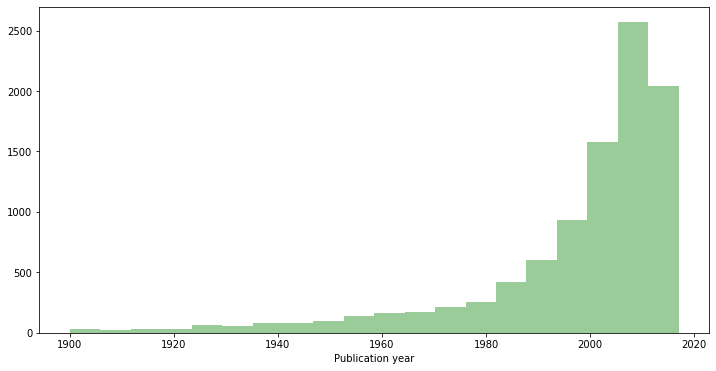

In [61]:
# Function that plots the distribution of the books by the year.
def plot_yearDistribution():
    # Filter books written from 1900
    plt.figure(figsize=(12, 6))
    years_filter = books[(books['original_publication_year'] >= 1900)]
    
    #Plot the distribution of the books by the publication year.
    sns.distplot(years_filter['original_publication_year'], kde=False, bins=20, color='green')
    plt.xlabel("Publication year")
    plt.show()

plot_yearDistribution()

### 13. Count the Highest rating count

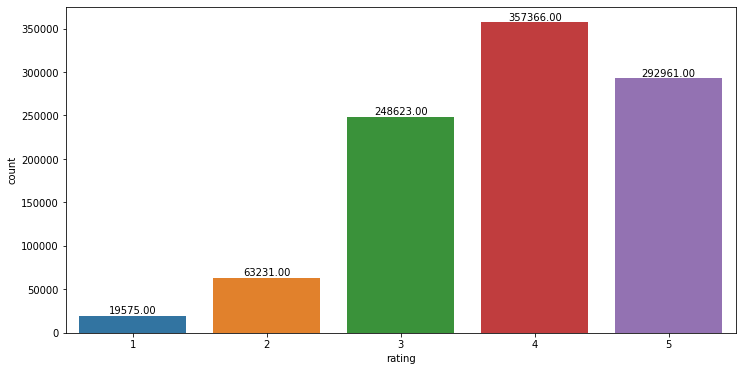

In [63]:
plt.figure(figsize=(12, 6))
plots = sns.countplot(data=ratings, x ='rating')
# Iterrating over the bars one-by-one
for bar in plots.patches:
	plots.annotate(format(bar.get_height(), '.2f'),
				(bar.get_x() + bar.get_width() / 2,
					bar.get_height()), ha='center', va='center',
				size=10, xytext=(0, 5),
				textcoords='offset points')
plt.show()

### 14.Top10 Tags of the books

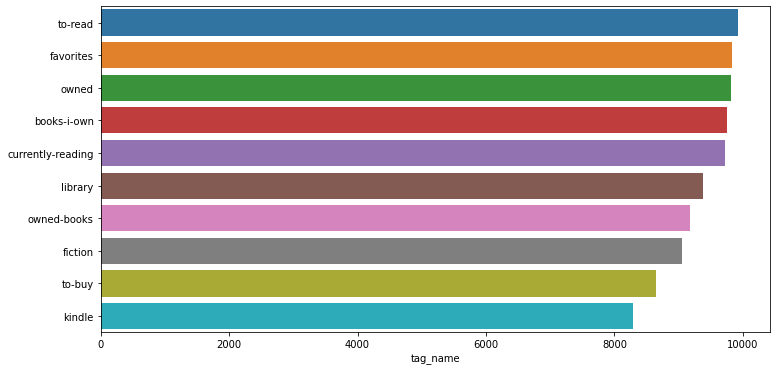

In [64]:
plt.figure(figsize=(12, 6))
top_tags = data['tag_name'].value_counts(ascending = False).head(10)
sns.barplot(x = top_tags, y=top_tags.index)
plt.show()

### 15.Correlation Checking

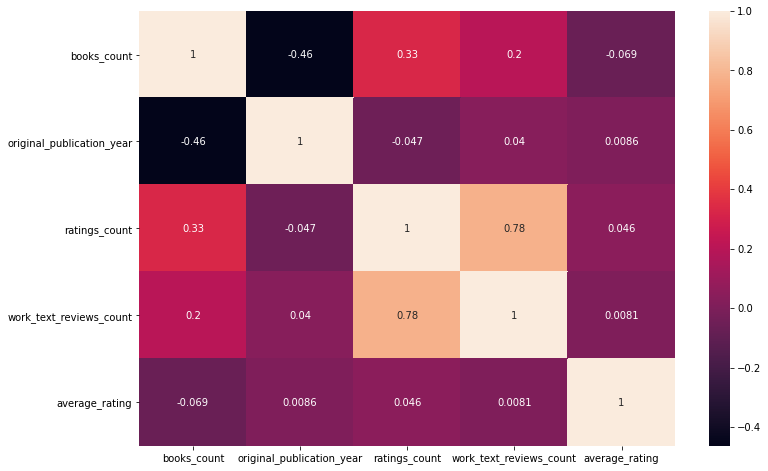

In [59]:
plt.figure(figsize=(12, 8))
corr = books[['books_count','original_publication_year','ratings_count','work_text_reviews_count','average_rating']].corr()
sns.heatmap(corr,annot=True)
plt.show()

### 16.Top 10 Books Contains highest Ratings

In [60]:
pd.set_option('display.max_colwidth', -1)
books[['title','ratings_count']].sort_values(by=['ratings_count'], ascending=False).head(10)

,title,ratings_count
0,"The Hunger Games (The Hunger Games, #1)",4780653
1,"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",4602479
2,"Twilight (Twilight, #1)",3866839
3,To Kill a Mockingbird,3198671
4,The Great Gatsby,2683664
5,The Fault in Our Stars,2346404
6,The Hobbit,2071616
7,The Catcher in the Rye,2044241
9,Pride and Prejudice,2035490
8,"Angels & Demons (Robert Langdon, #1)",2001311


### 17.Top 10 Higest average rating by book


In [65]:
books[['title','average_rating']].sort_values(by=['average_rating'], ascending=False).head(10)

,title,average_rating
3627,The Complete Calvin and Hobbes,4.82
3274,"Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)",4.77
861,"Words of Radiance (The Stormlight Archive, #2)",4.77
8853,Mark of the Lion Trilogy,4.76
7946,ESV Study Bible,4.76
4482,It's a Magical World: A Calvin and Hobbes Collection,4.75
421,"Harry Potter Boxset (Harry Potter, #1-7)",4.74
6360,There's Treasure Everywhere: A Calvin and Hobbes Collection,4.74
3752,"Harry Potter Collection (Harry Potter, #1-6)",4.73
6919,The Indispensable Calvin and Hobbes,4.73


### 18.Join all tags by Books

In [66]:
# For each book, join all their tags
list_tags = data.groupby(by="goodreads_book_id")["tag_name"].apply(set).apply(list)

# Append this list of tags on the books dataset
books["tags"] = books["goodreads_book_id"].apply(lambda x: " ".join(list_tags[x]))

In [68]:
pd.reset_option('max_colwidth')
books.head(2)

,book_id,goodreads_book_id,books_count,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_text_reviews_count,image_url,tags
0,1,2767052,272,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,155254,https://images.gr-assets.com/books/1447303603m...,ya-fiction my-favorites sf love books books-i-...
1,2,3,491,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,75867,https://images.gr-assets.com/books/1474154022m...,ya-fiction my-favorites read-in-2015 books boo...


### 19. Helping Function

In [85]:
# Function to get the index of the book given its title. 
def get_book_id(book_title):
    index = books.index[books['original_title'] == book_title].to_list()
    if index:
        return index[0]
    else:
        return None

# Function to get the title of a book given its id.
def get_book_title(book_id):
    title = books.iloc[book_id]['original_title']
    return title

### 20.TFIDF Count

![](https://miro.medium.com/max/1838/1*qQgnyPLDIkUmeZKN2_ZWbQ.png)

In [71]:
tfidf = TfidfVectorizer(stop_words='english')

tfidf_matrix = tfidf.fit_transform(books['tags'])

In [89]:
similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function that takes the book title and returns the most similar books.
def get_similar_books(title, n=10):
    
    # Get the book id
    book_id = get_book_id(title)
    
    if book_id is None:
        print("Book not found.")
    else:
        
        # Get the pariwsie similarity scores of all books with that book
        book_similarities = list(enumerate(similarities[book_id]))
        
        # Sort the books based on the similarity scores
        book_similarities = sorted(book_similarities, key=lambda x: x[1], reverse=True)
        
        # Get the scores of the 10 most similar book
        most_similar_books = book_similarities[1:1+n]
        movie_indices = [i[0] for i in most_similar_books]
   
    # Top 10 book recommendation
        rec = books[['title', 'image_url']].iloc[movie_indices]
        print("For this book we will recommand you:\n")
        for i in rec['image_url']:
            response = requests.get(i)
            img = Image.open(BytesIO(response.content))
            plt.figure()
            plt.imshow(img)
            plt.axis('off')
            plt.show()

For this book we will recommand you:



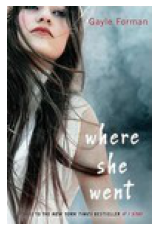

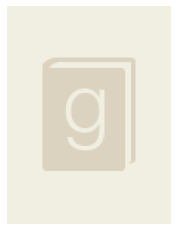

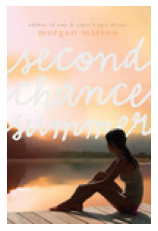

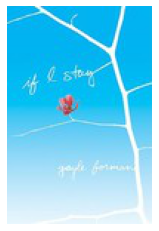

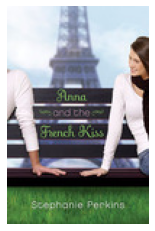

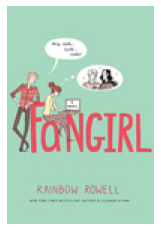

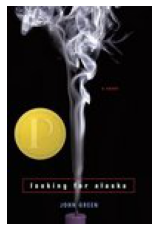

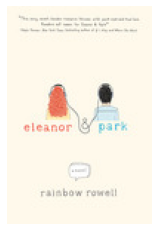

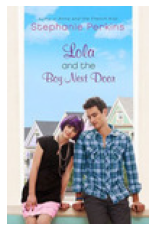

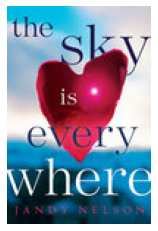

In [95]:
get_similar_books("The Fault in Our Stars")

In [99]:
# tfidf_matrix1 = tfidf.fit_transform(books['authors'])
# similarities = cosine_similarity(tfidf_matrix1, tfidf_matrix1)
# get_similar_books("J.K. Rowling")

### 21. Desiggn Book Corpus

In [100]:
books['corpus'] = (pd.Series(books[['authors', 'tags']]
                .fillna('')
                .values.tolist()
                ).str.join(' '))

### 22.Calculate Similarity with Pairwise Linear Kernel
Reading : [Linear Kernel](https://scikit-learn.org/stable/modules/metrics.html#linear-kernel)

* Ngram

![](https://i.stack.imgur.com/8ARA1.png)

In [102]:
# Data
tf_corpus = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix_corpus = tf_corpus.fit_transform(books['corpus'].values.astype('U'))

# Moel
cosine_sim_corpus = linear_kernel(tfidf_matrix_corpus, tfidf_matrix_corpus)

# Build a 1-dimensional array with book titles
titles = books['title']
indices = pd.Series(books.index, index=books['title'])

# Function that get book recommendations based on the cosine similarity score of books tags
def corpus_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim_corpus[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    book_indices = [i[0] for i in sim_scores]
    return titles.iloc[book_indices]

In [103]:
corpus_recommendations("Twilight (Twilight, #1)")

51                                 Eclipse (Twilight, #3)
48                                New Moon (Twilight, #2)
984            The Big Short: Inside the Doomsday Machine
827     Persepolis: The Story of a Childhood (Persepol...
727              Brown Bear, Brown Bear, What Do You See?
1607                      Paranormalcy (Paranormalcy, #1)
4066                             The Eight (The Eight #1)
72                                The Host (The Host, #1)
2009                                        Black Like Me
55                           Breaking Dawn (Twilight, #4)
Name: title, dtype: object

In [104]:
corpus_recommendations("To Kill a Mockingbird")

7                  The Catcher in the Rye
4                        The Great Gatsby
31                        Of Mice and Men
27                      Lord of the Flies
129               The Old Man and the Sea
128       One Flew Over the Cuckoo's Nest
776                              Jemima J
463        Holy Bible: King James Version
57     The Adventures of Huckleberry Finn
127                            Steve Jobs
Name: title, dtype: object

### 23.Author Recommendation using Linear kernel

In [105]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(books['authors'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [106]:
# Build a 1-dimensional array with book titles
titles = books['title']
indices = pd.Series(books.index, index=books['title'])

# Function that get book recommendations based on the cosine similarity score of book authors
def authors_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    book_indices = [i[0] for i in sim_scores]
    return titles.iloc[book_indices]

In [107]:
authors_recommendations("Twilight (Twilight, #1)")

48                                New Moon (Twilight, #2)
51                                 Eclipse (Twilight, #3)
55                           Breaking Dawn (Twilight, #4)
72                                The Host (The Host, #1)
731     The Short Second Life of Bree Tanner: An Eclip...
833                         Midnight Sun (Twilight, #1.5)
1618    The Twilight Saga Complete Collection  (Twilig...
2020             The Twilight Collection (Twilight, #1-3)
4087    The Twilight Saga: The Official Illustrated Gu...
5295                                          The Chemist
Name: title, dtype: object

###  24.Book Recommendation based on User Interest

In [109]:
newer_books = books[books['original_publication_year'] > 2000]

df_books = newer_books[['book_id','original_title', 'title']]

# We are left with the ratings that have been made to the books from the year 2000.
df_ratings = ratings[ratings.book_id.isin(df_books.book_id)]

In [110]:
# Count the users that has voted more than 100 times. 
user_counts = df_ratings['user_id'].value_counts()
df_ratings = df_ratings[df_ratings['user_id'].isin(user_counts[user_counts >= 100].index)]

In [111]:
df_titles = df_books[['book_id','title']]
df_titles.set_index('book_id', inplace = True)

In [112]:
def recommend_books(user_id):
    
    # Getting all the ratings that has done the user
    user = df_ratings[df_ratings['user_id'] == user_id]
    user = user.join(df_titles)['title']
    
    user = df_titles.copy()
    user = user.reset_index()
    
    # We get the books that the user has not yet read. 
    user = user[~user['book_id'].isin(df_books)]
    
    # We check the predicted score using the predict function and getting the estimation.
    user['estimate_score'] = user['book_id'].apply(lambda x: algo.predict(user_id, x).est)
    
    # Sort the books by the estimate score that the predict returns.
    user = user.drop('book_id', axis=1)
    user = user.sort_values('estimate_score', ascending=False)
    
    return user.head(10)


In [113]:
from surprise import SVD,Reader,Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold

In [117]:
reader = Reader()

data = Dataset.load_from_df(df_ratings[['user_id','book_id','rating']], reader)
kf = KFold(n_splits=5)
kf.split(data)
algo = SVD()
# Run 5-fold cross-validation and then print results
analysis = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
pd.DataFrame(analysis)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8503  0.8278  0.8256  0.8424  0.8354  0.8363  0.0092  
MAE (testset)     0.6460  0.6365  0.6363  0.6419  0.6449  0.6411  0.0041  
Fit time          1.11    1.11    1.11    1.11    1.12    1.11    0.00    
Test time         0.04    0.04    0.03    0.03    0.03    0.04    0.00    


,test_rmse,test_mae,fit_time,test_time
0,0.850256,0.646016,1.114840,0.044004
1,0.827812,0.636506,1.110099,0.037401
2,0.825565,0.636288,1.108981,0.033224
3,0.842351,0.641935,1.107906,0.033696
4,0.835425,0.644929,1.119455,0.034106


In [119]:
trainset = data.build_full_trainset()
algo.fit(trainset)

In [120]:
user_id = 127
recommend_books(user_id)

,title,estimate_score
399,"Words of Radiance (The Stormlight Archive, #2)",4.571464
619,"Queen of Shadows (Throne of Glass, #4)",4.553018
251,"The Way of Kings (The Stormlight Archive, #1)",4.536987
486,"Heir of Fire (Throne of Glass, #3)",4.504306
121,The Nightingale,4.463124
118,The Shadow of the Wind (The Cemetery of Forgot...,4.450078
588,A Little Life,4.417460
750,"An Ember in the Ashes (An Ember in the Ashes, #1)",4.408346
1075,"American Assassin (Mitch Rapp, #1)",4.408103
650,A Court of Mist and Fury (A Court of Thorns an...,4.393789


### References

1. https://medium.com/web-mining-is688-spring-2021/my-kind-of-books-142053b3c0d6